In [1]:
# Load librarie
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

warnings.filterwarnings("ignore")
%matplotlib inline
sns.set(rc={"figure.figsize": (20, 15)})
sns.set_style("whitegrid")

In [2]:
# Import datasets 

# Train set
df_train = pd.read_csv(r"C:\Users\Walte\Desktop\House pricing\train.csv")
print(f"Train set info:\n{df_train.shape}\n")

# Test set
df_test = pd.read_csv(r"C:\Users\Walte\Desktop\House pricing\test.csv")
print(f"Test set info:\n{df_test.shape}")

Train set info:
(1460, 81)

Test set info:
(1459, 80)


In [3]:
# train data info 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# Comparing train and test data set with the same column 
dif_1 = [x for x in df_train.columns if x not in df_test.columns]
print(f"Columns present in df_train and not in df_test: {dif_1}\n")

dif_2 = [x for x in df_test.columns if x not in df_train.columns]
print(f"Columns present in df_test and not in df_train: {dif_2}")

Columns present in df_train and not in df_test: ['SalePrice']

Columns present in df_test and not in df_train: []


In [5]:
# Drop the 'Id' column from the train set becuase it is not a factor 
df_train.drop(["Id"], axis=1, inplace=True)

# Save the list of 'Id' before dropping it from the test set
Id_test_list = df_test["Id"].tolist()
df_test.drop(["Id"], axis=1, inplace=True)

In [6]:
# Select the numerical data of train data 
df_train_num = df_train.select_dtypes(exclude=["object"])
df_train_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


In [7]:
# Quasi-constant (95%)
sel = VarianceThreshold(threshold=0.05)

# fit finds the features with constant variance
sel.fit(df_train_num.iloc[:, :-1])


# Number that not constant 
print(f"Number of retained features: {sum(sel.get_support())}")
print(f"Number of quasi_constant features: {len(df_train_num.iloc[:, :-1].columns) - sum(sel.get_support())}")

quasi_constant_features_list = [x for x in df_train_num.iloc[:, :-1].columns if x not in df_train_num.iloc[:, :-1].columns[sel.get_support()]]
print(f"Quasi-constant features to be dropped: {quasi_constant_features_list}")


# Let's drop these columns from df_train_num
df_train_num.drop(quasi_constant_features_list, axis=1, inplace=True)

Number of retained features: 35
Number of quasi_constant features: 1
Quasi-constant features to be dropped: ['KitchenAbvGr']


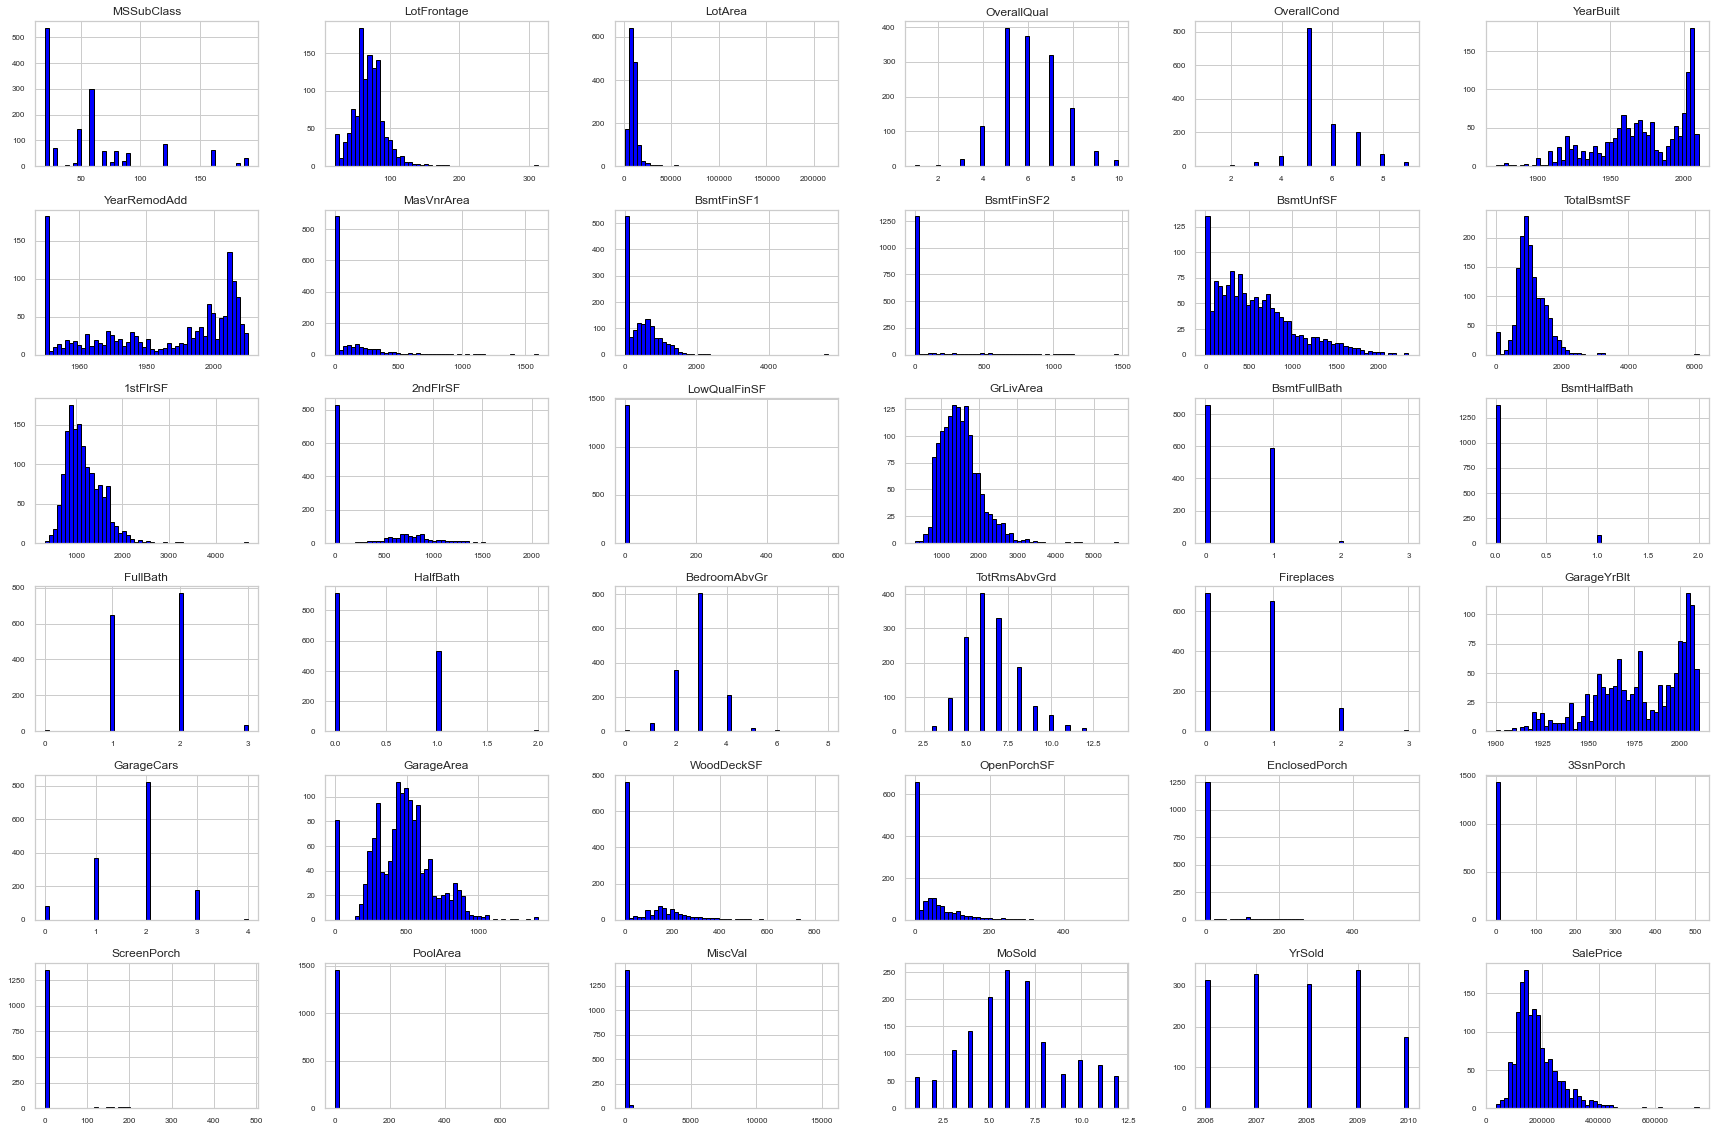

In [8]:
# Visualization of all the numerical data
fig_ = df_train_num.hist(figsize=(30, 20), bins=50, color="blue",
                         edgecolor="black", xlabelsize=8, ylabelsize=8)

<AxesSubplot:>

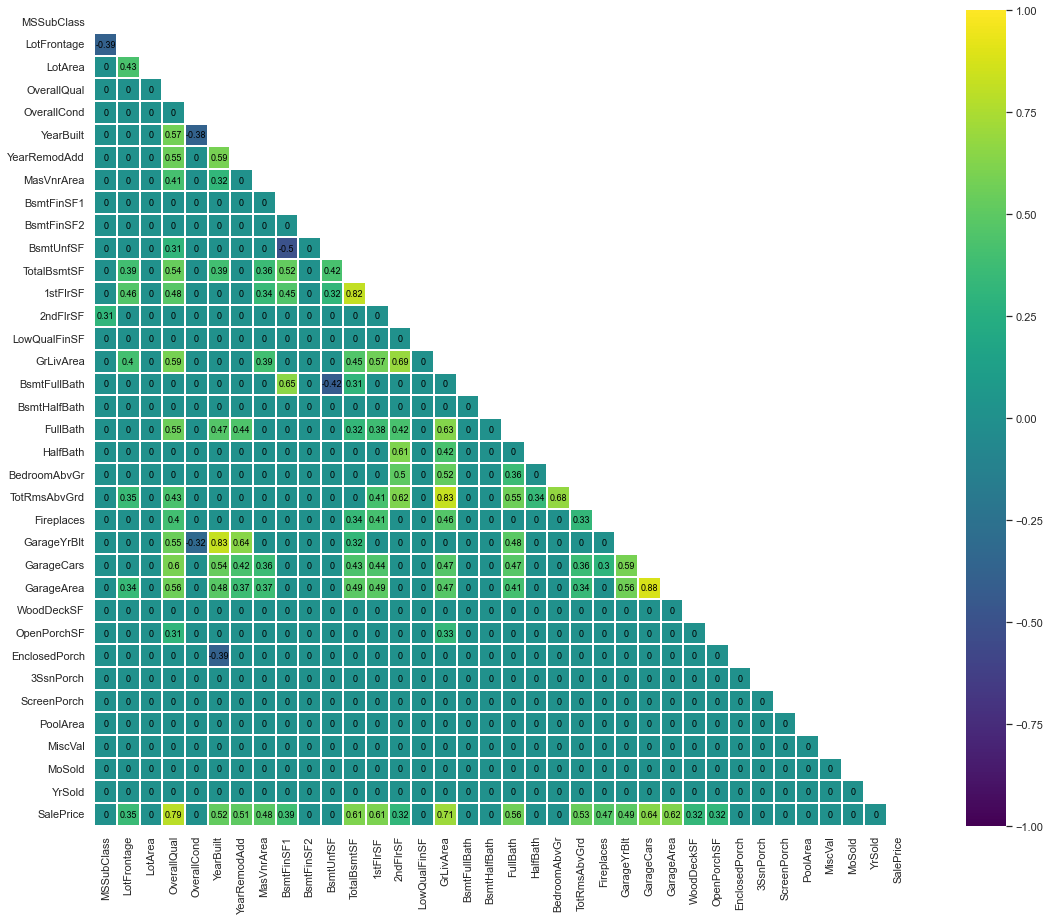

In [9]:
# Heatmap for all the remaining numerical data including the taget 'SalePrice'

pd.options.display.float_format = "{:,.2f}".format
corr_matrix = df_train_num.corr()
corr_matrix[(corr_matrix < 0.3) & (corr_matrix > -0.3)] = 0
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = "viridis"
sns.heatmap(corr_matrix, mask=mask, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 9, "color": "black"}, square=True, cmap=cmap, annot=True)

In [10]:
# 18 features that are important and correlated (correlation higher than absolute 0.3) with our target variable 'SalePrice'. 
# In next, select features where the correlation with 'SalePrice' is higher than |0.3| 

In [11]:
# SalePrice
df_num_corr = df_train_num.corr()["SalePrice"][:-1]

# r2 > 0.5
high_features_list = df_num_corr[abs(
    df_num_corr) >= 0.5].sort_values(ascending=False)
print(
    f"{len(high_features_list)} strongly correlated values with SalePrice:\n{high_features_list}\n")

# r2 < 0.5 & r2 > 0.3
low_features_list = df_num_corr[(abs(df_num_corr) < 0.5) & (
    abs(df_num_corr) >= 0.3)].sort_values(ascending=False)
print(
    f"{len(low_features_list)} slightly correlated values with SalePrice:\n{low_features_list}")

10 strongly correlated values with SalePrice:
OverallQual    0.79
GrLivArea      0.71
GarageCars     0.64
GarageArea     0.62
TotalBsmtSF    0.61
1stFlrSF       0.61
FullBath       0.56
TotRmsAbvGrd   0.53
YearBuilt      0.52
YearRemodAdd   0.51
Name: SalePrice, dtype: float64

8 slightly correlated values with SalePrice:
GarageYrBlt   0.49
MasVnrArea    0.48
Fireplaces    0.47
BsmtFinSF1    0.39
LotFrontage   0.35
WoodDeckSF    0.32
2ndFlrSF      0.32
OpenPorchSF   0.32
Name: SalePrice, dtype: float64


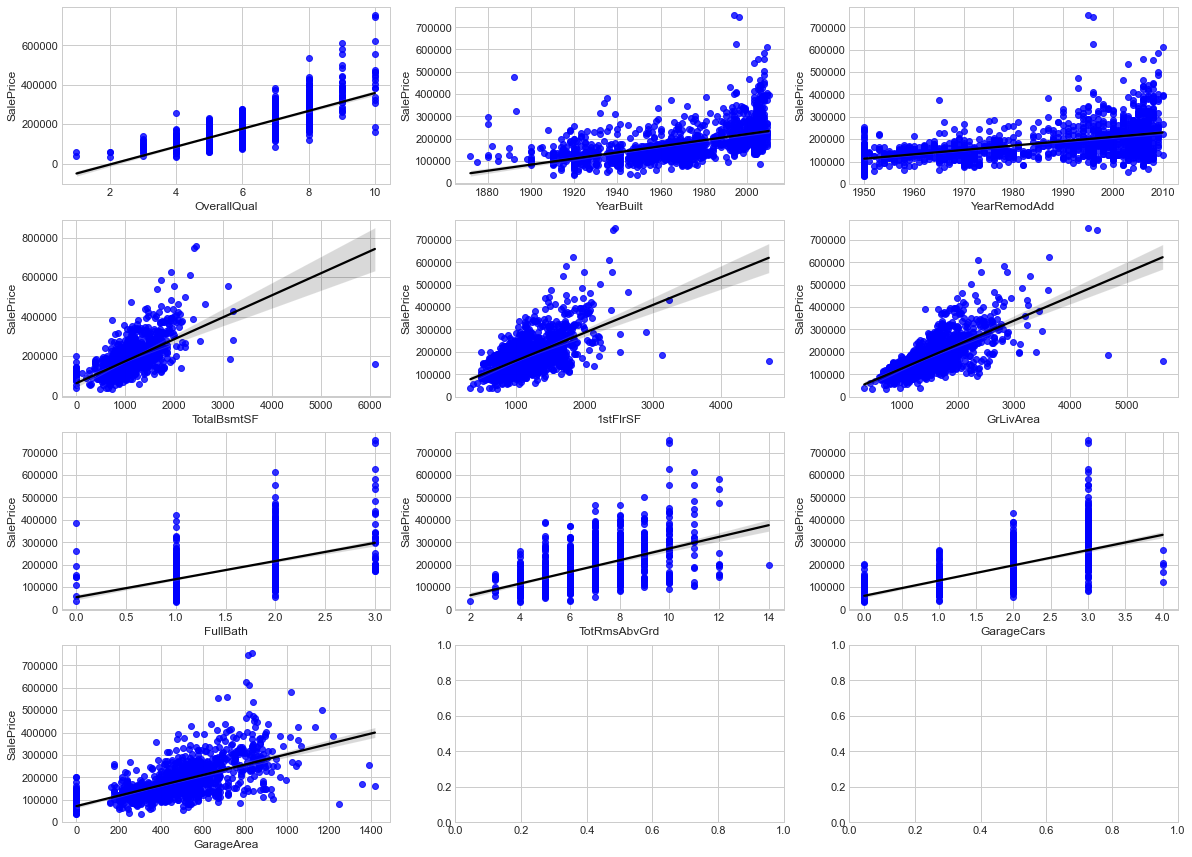

In [12]:
# Features with high correlation (higher than 0.5), plot the correlation of each featyre to salesprice 
strong_features = df_num_corr[abs(df_num_corr) > 0.5].index.tolist()
strong_features.append("SalePrice")
df_strong_features = df_train_num.loc[:, strong_features]

plt.style.use("seaborn-whitegrid")  
fig, ax = plt.subplots(round(len(strong_features) / 3), 3)

for i, ax in enumerate(fig.axes):
    if i < len(strong_features)-1:
        sns.regplot(x=strong_features[i], y="SalePrice", data=df_strong_features, ax=ax, scatter_kws={
                    "color": "blue"}, line_kws={"color": "black"})

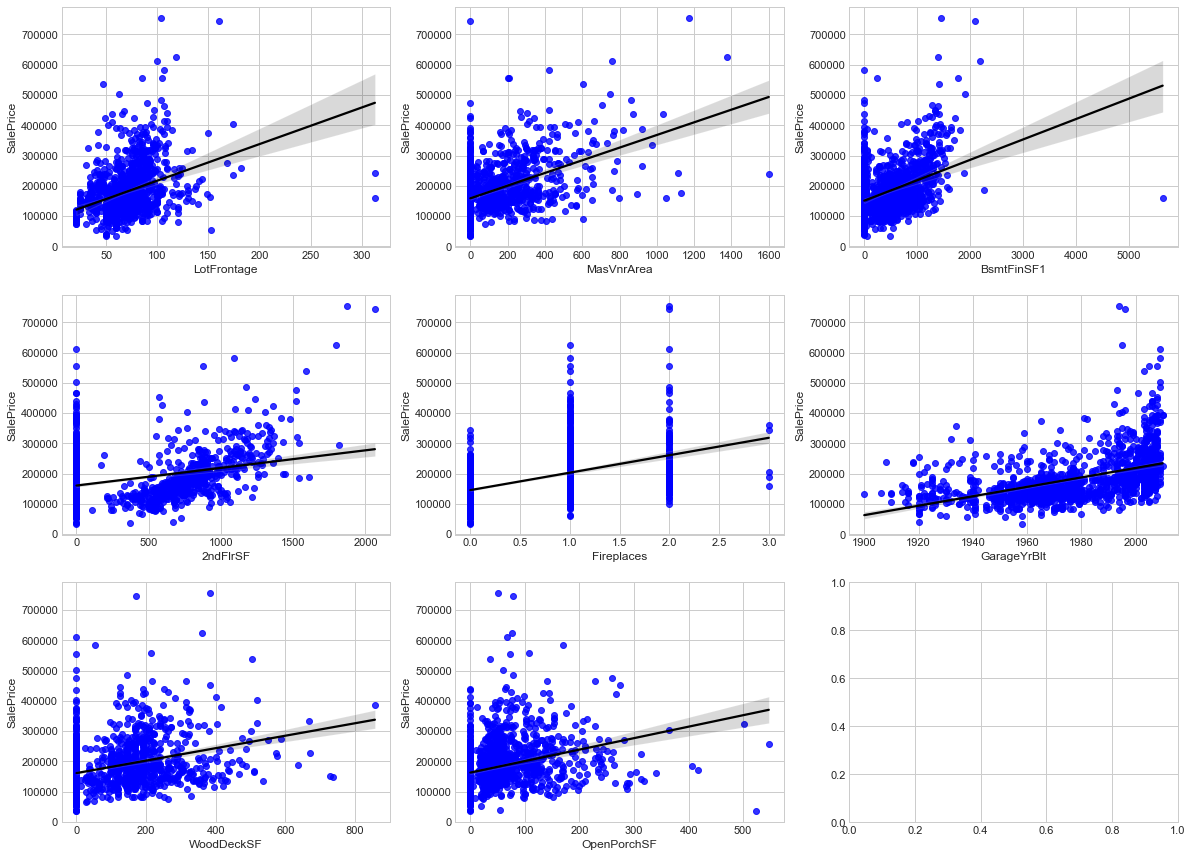

In [13]:
# Features with low correlation (between 0.3 and 0.5), plot the correlation of each feature with Salesprice 
low_features = df_num_corr[(abs(df_num_corr) >= 0.3) & (
    abs(df_num_corr) < 0.5)].index.tolist()
low_features.append("SalePrice")

df_low_features = df_train_num.loc[:, low_features]

plt.style.use("seaborn-whitegrid")  
fig, ax = plt.subplots(round(len(low_features) / 3), 3)

for i, ax in enumerate(fig.axes):
    if i < len(low_features) - 1:
        sns.regplot(x=low_features[i], y="SalePrice", data=df_low_features, ax=ax, scatter_kws={
                    "color": "blue"}, line_kws={"color": "black"},)

In [14]:
# Remove observations to avoid influencing the prediction model

In [15]:
# Define the list of numerical fetaures to keep
list_of_numerical_features = strong_features[:-1] + low_features

# Let's select these features form our train set
df_train_num = df_train_num.loc[:, list_of_numerical_features]

# The same features are selected from the test set (-1 -> except 'SalePrice')
df_test_num = df_test.loc[:, list_of_numerical_features[:-1]]

Text(0, 0.5, 'Column Name\n')

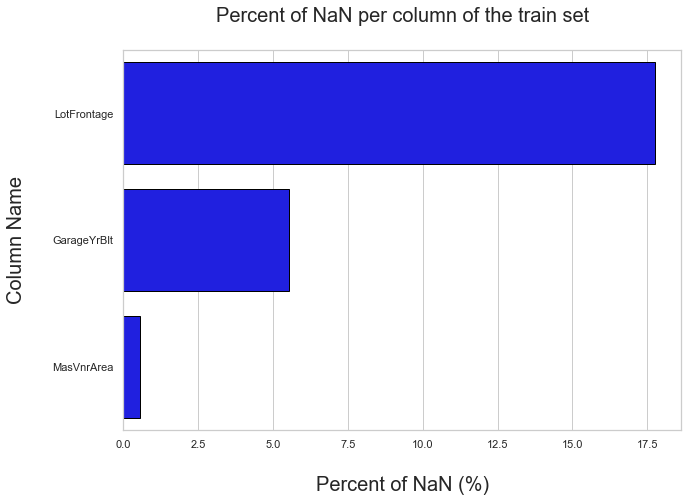

In [16]:
# Check the non-number (NAN) of the train set by ploting percent of missing values per column
column_with_nan = df_train_num.columns[df_train_num.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(
        round(df_train_num[i].isnull().sum()*100/len(df_train_num), 2))

tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


# Define figure parameters
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")

# Plot results
p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="blue")

p.set_title("Percent of NaN per column of the train set\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=20)
p.set_ylabel("Column Name\n", fontsize=20)

In [17]:
# Imputation of missing values (NaN) with SimpleImputer
my_imputer = SimpleImputer(strategy="median")
df_train_imputed = pd.DataFrame(my_imputer.fit_transform(df_train_num))
df_train_imputed.columns = df_train_num.columns

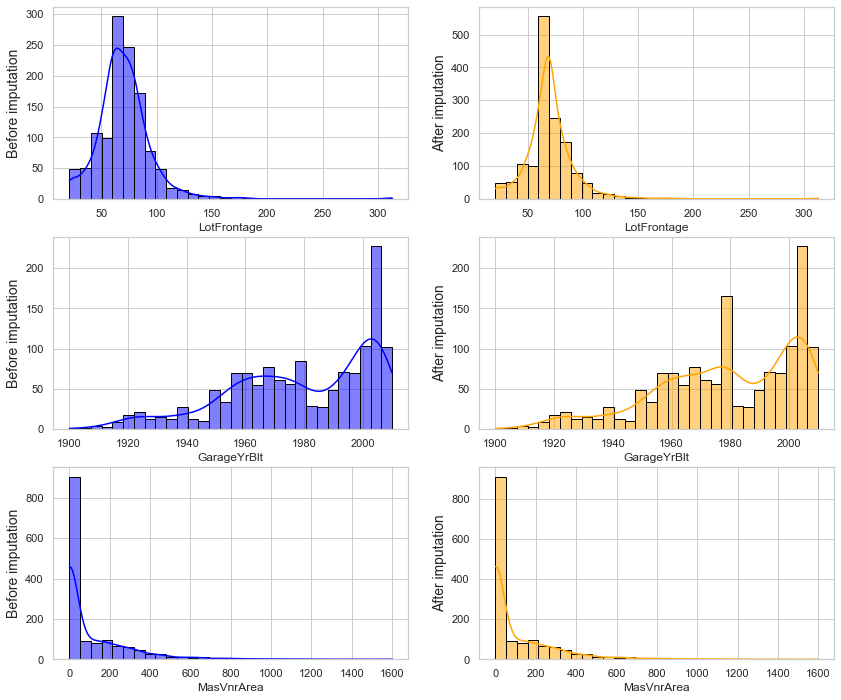

In [18]:
# Let's check the distribution of each imputed feature before and after imputation

# Define figure parameters
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 2)

# Plot the results
for feature, fig_pos in zip(["LotFrontage", "GarageYrBlt", "MasVnrArea"], [0, 1, 2]):

    """Features distribution before and after imputation"""

    # before imputation
    p = sns.histplot(ax=axes[fig_pos, 0], x=df_train_num[feature],
                     kde=True, bins=30, color="blue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)

    # after imputation
    q = sns.histplot(ax=axes[fig_pos, 1], x=df_train_imputed[feature],
                     kde=True, bins=30, color="orange", edgecolor="black")
    q.set_ylabel(f"After imputation", fontsize=14)

In [19]:
# For "LotFrontage" and "GarageYrBlt" the distributions have changed after imputations. 
# There is an over-representation of the median class compare ot the original distribution. However, the distribution remains the same for "MasVnrArea". 
# Thus, to avoid any error related to the imputation I keep only the feature "MasVnrArea" for my analyses.

In [20]:
# Drop 'LotFrontage' and 'GarageYrBlt'
df_train_imputed.drop(["LotFrontage", "GarageYrBlt"], axis=1, inplace=True)
df_train_imputed.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,MasVnrArea,BsmtFinSF1,2ndFlrSF,Fireplaces,WoodDeckSF,OpenPorchSF,SalePrice
0,7.00,"2,003.00","2,003.00",856.00,856.00,"1,710.00",2.00,8.00,2.00,548.00,196.00,706.00,854.00,0.00,0.00,61.00,"208,500.00"
1,6.00,"1,976.00","1,976.00","1,262.00","1,262.00","1,262.00",2.00,6.00,2.00,460.00,0.00,978.00,0.00,1.00,298.00,0.00,"181,500.00"
2,7.00,"2,001.00","2,002.00",920.00,920.00,"1,786.00",2.00,6.00,2.00,608.00,162.00,486.00,866.00,1.00,0.00,42.00,"223,500.00"
3,7.00,"1,915.00","1,970.00",756.00,961.00,"1,717.00",1.00,7.00,3.00,642.00,0.00,216.00,756.00,1.00,0.00,35.00,"140,000.00"
4,8.00,"2,000.00","2,000.00","1,145.00","1,145.00","2,198.00",2.00,9.00,3.00,836.00,350.00,655.00,"1,053.00",1.00,192.00,84.00,"250,000.00"


In [21]:
# The columns that have been deleted in the train set must also be deleted in the test 

In [22]:
df_test_num.drop(["LotFrontage", "GarageYrBlt"], axis=1, inplace=True)

Text(0, 0.5, 'Column Name\n')

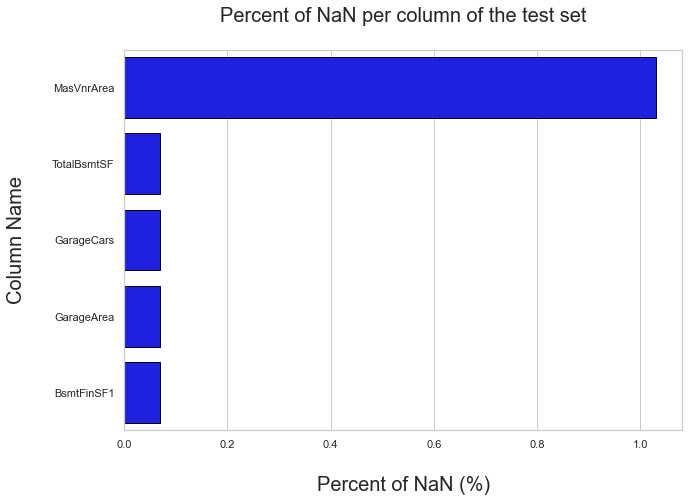

In [23]:
# Repeat NAN for test set by plotting percent of missing value 

column_with_nan = df_test_num.columns[df_test_num.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(
        round(df_test_num[i].isnull().sum()*100/len(df_test_num), 2))

tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)

sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")
p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="blue")

p.set_title("Percent of NaN per column of the test set\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=20)
p.set_ylabel("Column Name\n", fontsize=20)

In [24]:
# Repeat Imputation 
my_imputer = SimpleImputer(strategy="median")
df_test_imputed = pd.DataFrame(my_imputer.fit_transform(df_test_num))
df_test_imputed.columns = df_test_num.columns

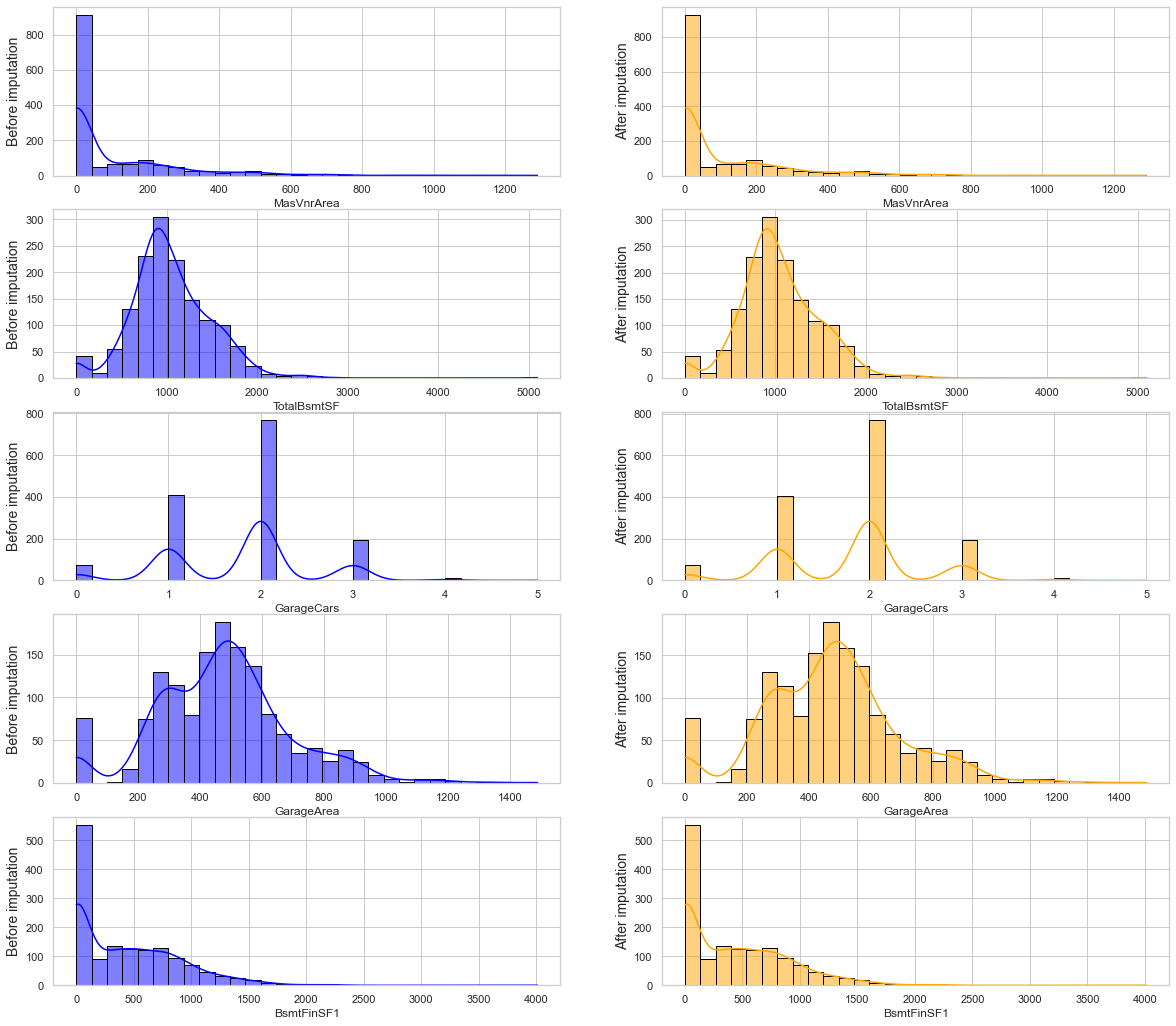

In [25]:
# Comparation before and after imputation 


sns.set(rc={"figure.figsize": (20, 18)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(5, 2)

for feature, fig_pos in zip(tab["Column"].tolist(), range(0, 6)):

    """Features distribution before and after imputation"""
    # before 
    p = sns.histplot(ax=axes[fig_pos, 0], x=df_test_num[feature],
                     kde=True, bins=30, color="blue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)
    
    # after 
    q = sns.histplot(ax=axes[fig_pos, 1], x=df_test_imputed[feature],
                     kde=True, bins=30, color="orange", edgecolor="black",)
    q.set_ylabel(f"After imputation", fontsize=14)

In [26]:
# the percentage of NaN in each of these fetaures did not exceed 1.5%. Imputation success 

In [27]:
# Categorical to Quantitative relationship
categorical_features = [
    i for i in df_train.columns if df_train.dtypes[i] == "object"]
categorical_features.append("SalePrice")

# Train set
df_train_categ = df_train[categorical_features]

# Test set (-1 because test set don't have 'Sale Price')
df_test_categ = df_test[categorical_features[:-1]]

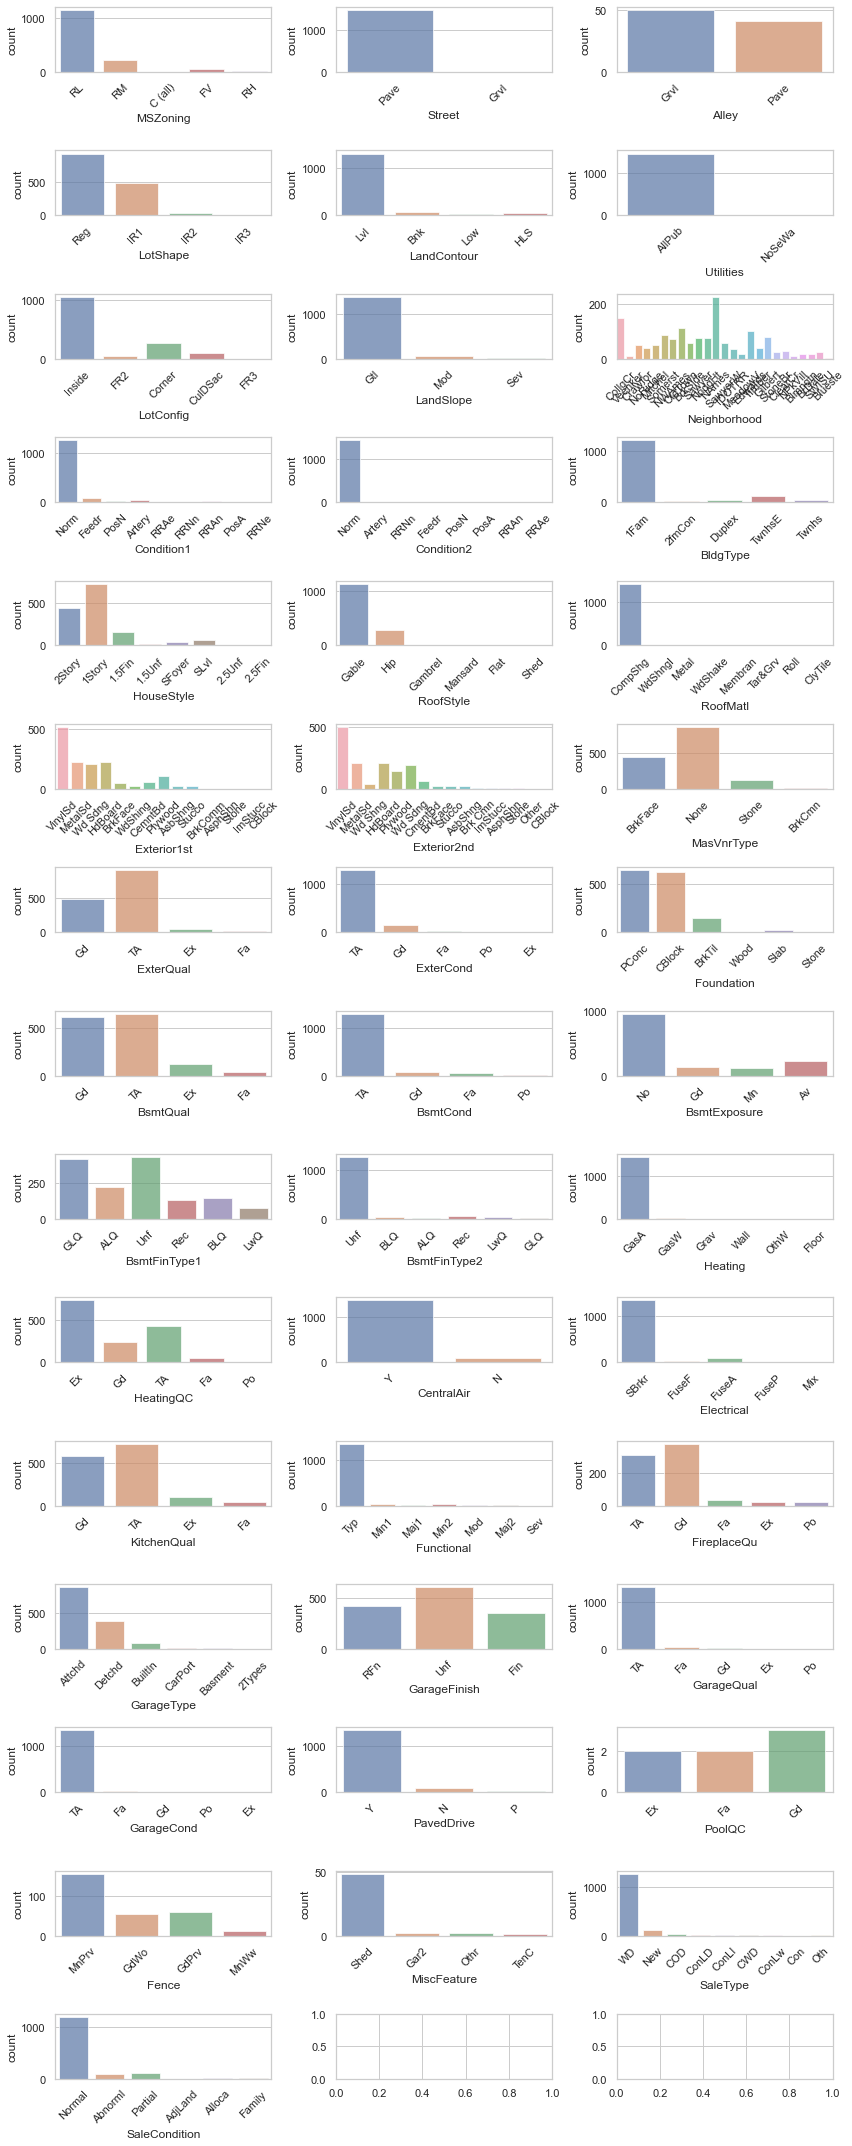

In [28]:
# Countplot for each of the categorical features in the train set
fig, axes = plt.subplots(
    round(len(df_train_categ.columns) / 3), 3, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_train_categ.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(
            x=df_train_categ.columns[i], alpha=0.7, data=df_train_categ, ax=ax)

fig.tight_layout()

In [29]:
# Drop the unimportant parts 

columns_to_drop = [
    "Street",
    "Alley",
    "LandContour",
    "Utilities",
    "LandSlope",
    "Condition2",
    "RoofMatl",
    "CentralAir",
    "GarageQual",
    "GarageCond",
    "SaleType",
    "PavedDrive",
    "LandContour",
    "ExterCond",
    "GarageCond",
    "Heating",
    "MiscFeature",
    "BsmtFinType2",
    "Functional",
    "GarageQual",
    "GarageCond",
]

# Train set
df_train_categ.drop(columns_to_drop, axis=1, inplace=True)

# Test set
df_test_categ.drop(columns_to_drop, axis=1, inplace=True)

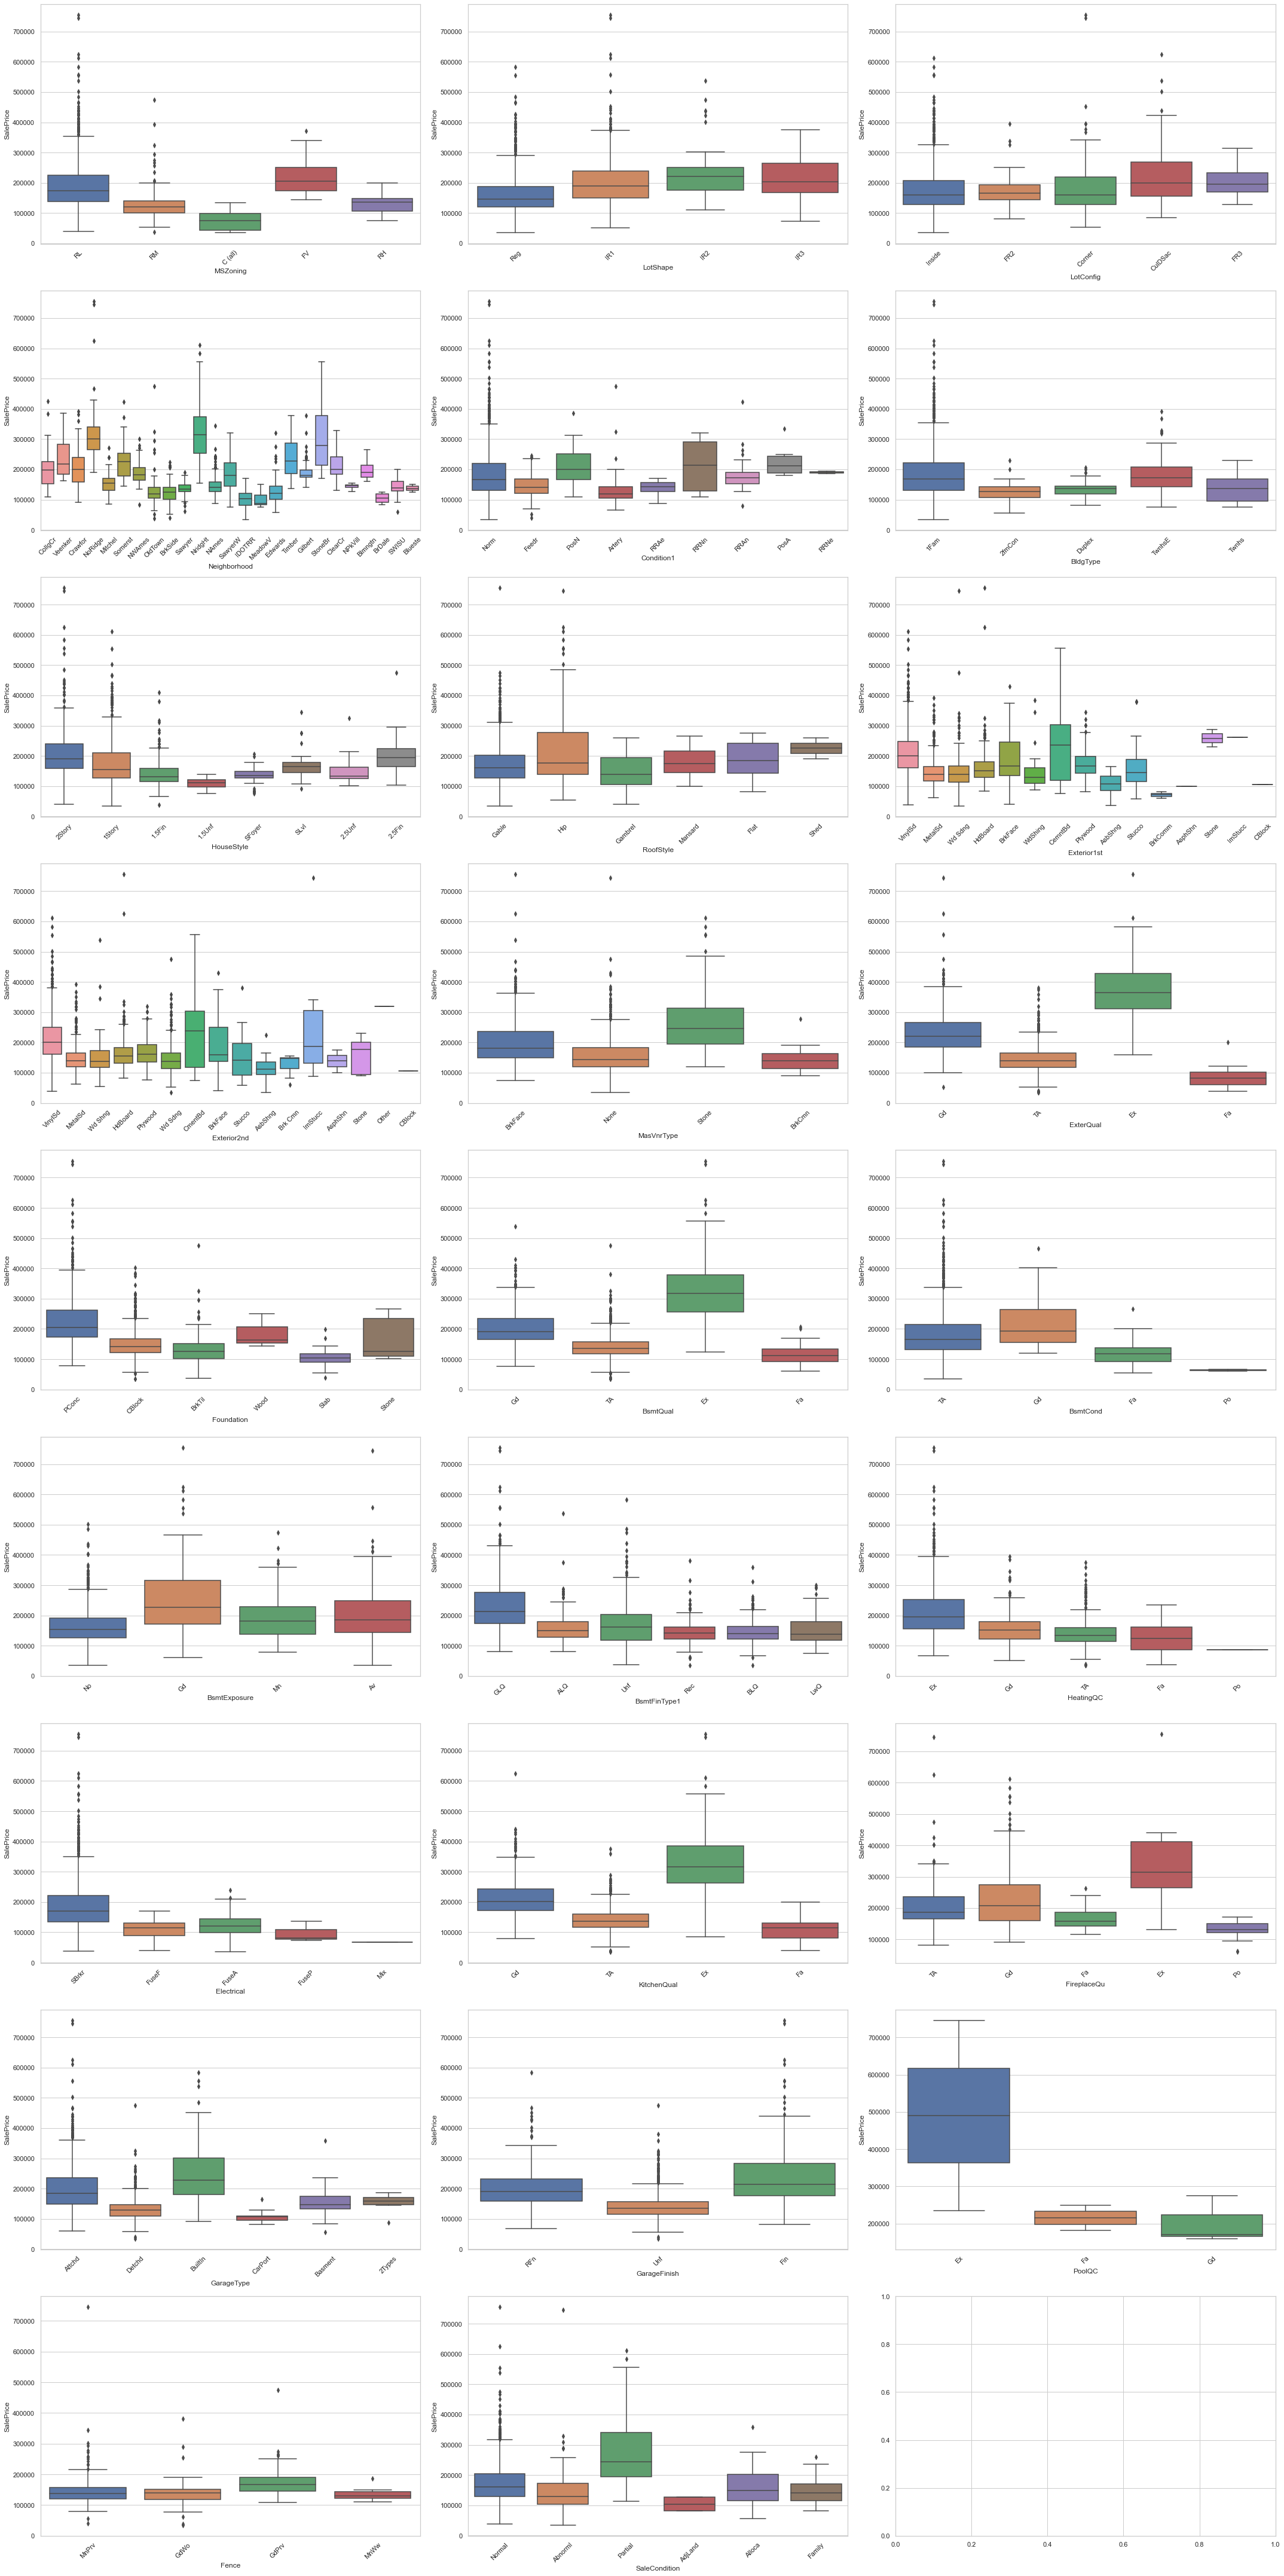

In [30]:
# Create boxplot show the variation of the target 'SalePrice' in each of the categorical features
fig, axes = plt.subplots(
    round(len(df_train_categ.columns)/3), 3, figsize=(30, 60))

for i, ax in enumerate(fig.axes):
    if i < len(df_train_categ.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(
            x=df_train_categ.columns[i], y="SalePrice", data=df_train_categ, ax=ax)

fig.tight_layout()

In [31]:
#  plot the contingency table and perform the Chi square test in order to identify these codependency

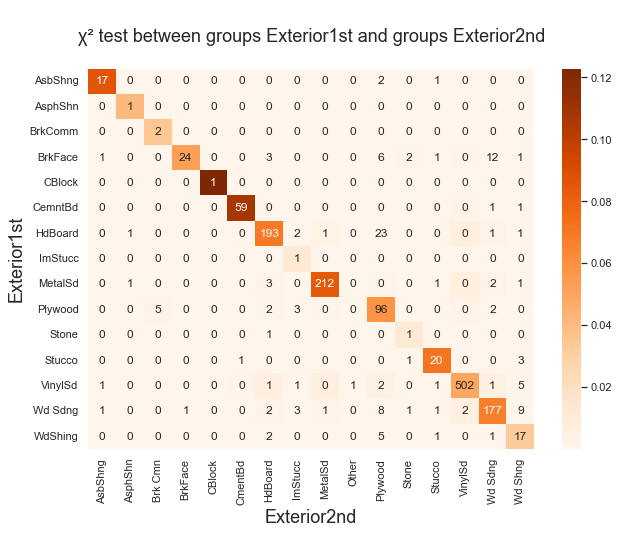

P-Value of the ChiSq Test bewteen Exterior1st and Exterior2nd is: 0.0



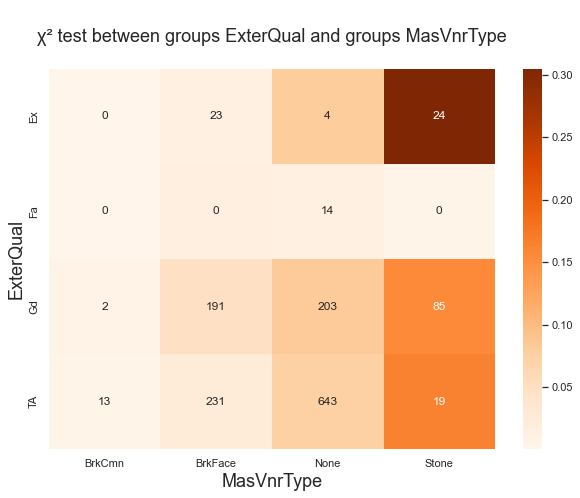

P-Value of the ChiSq Test bewteen ExterQual and MasVnrType is: 1.0187554679218715e-54



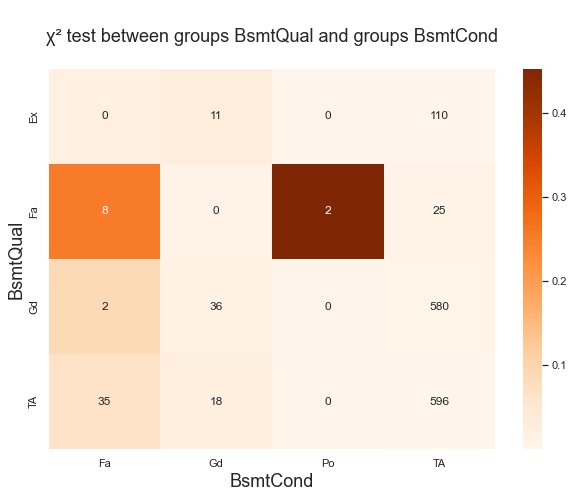

P-Value of the ChiSq Test bewteen BsmtQual and BsmtCond is: 1.9371809126533347e-31



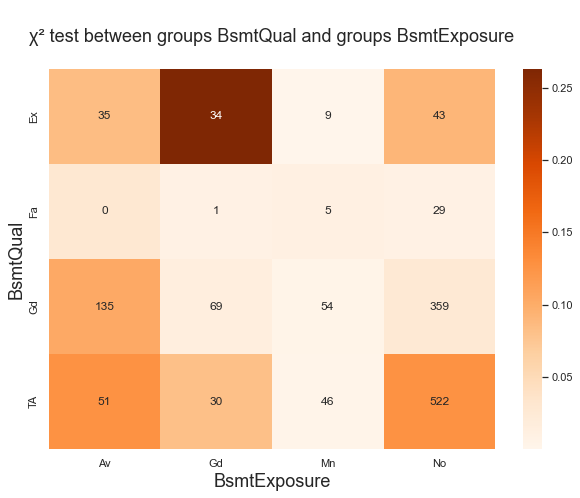

P-Value of the ChiSq Test bewteen BsmtQual and BsmtExposure is: 3.879215036512606e-32



In [32]:
# Plot contingency table

sns.set(rc={"figure.figsize": (10, 7)})

X = ["Exterior1st", "ExterQual", "BsmtQual", "BsmtQual", "BsmtQual"]
Y = ["Exterior2nd", "MasVnrType", "BsmtCond", "BsmtExposure"]

for i, j in zip(X, Y):

    # Contingency table
    cont = df_train_categ[[i, j]].pivot_table(
        index=i, columns=j, aggfunc=len, margins=True, margins_name="Total")
    tx = cont.loc[:, ["Total"]]
    ty = cont.loc[["Total"], :]
    n = len(df_train_categ)
    indep = tx.dot(ty) / n
    c = cont.fillna(0)  
    measure = (c - indep) ** 2 / indep
    xi_n = measure.sum().sum()
    table = measure / xi_n

    # Plot contingency table
    p = sns.heatmap(table.iloc[:-1, :-1],
                    annot=c.iloc[:-1, :-1], fmt=".0f", cmap="Oranges")
    p.set_xlabel(j, fontsize=18)
    p.set_ylabel(i, fontsize=18)
    p.set_title(f"\nχ² test between groups {i} and groups {j}\n", size=18)
    plt.show()

    # Performing Chi-sq test
    CrosstabResult = pd.crosstab(
        index=df_train_categ[i], columns=df_train_categ[j])
    ChiSqResult = chi2_contingency(CrosstabResult)
    # P-Value is the Probability of H0 being True
    print(
        f"P-Value of the ChiSq Test bewteen {i} and {j} is: {ChiSqResult[1]}\n")

In [33]:
# p-value is significant for all tests so there is some co-dependence between these variables.
#  For this I will drop 'Exterior2nd', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1' and 'MasVnrType'

# Train set
df_train_categ.drop(Y, axis=1, inplace=True)

# Test set
df_test_categ.drop(Y, axis=1, inplace=True)

Text(0, 0.5, 'Column Name\n')

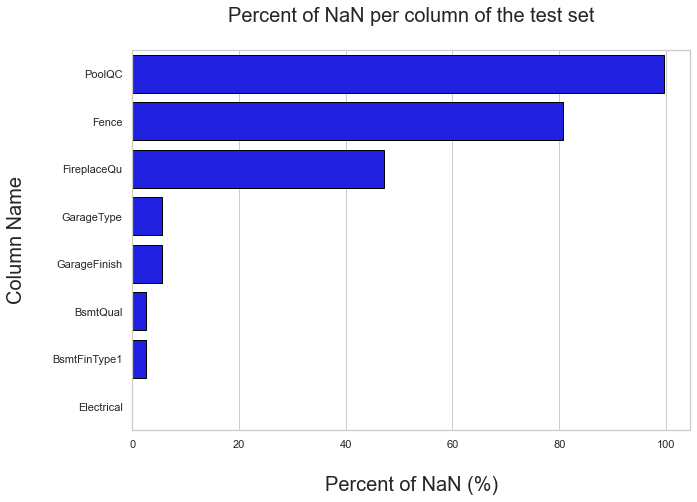

In [34]:
# Check the NaN of the test set by ploting percent of missing values per column
column_with_nan = df_train_categ.columns[df_train_categ.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(
        round(df_train_categ[i].isnull().sum() * 100 / len(df_train_categ), 2))

tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


# Define figure parameters
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")

# Plot results
p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="blue")
p.set_title("Percent of NaN per column of the test set\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=20)
p.set_ylabel("Column Name\n", fontsize=20)

In [35]:
# Drop the features where the percentage of NaN is higher than 5% to avoid introducing any error. 
# Then impute the NaN of 'BsmtQual' and 'Electrical' by the corresponding modal class

In [36]:
# Drop the features where the percentage of NaN is higher than 5%
df_train_categ.drop(["PoolQC", "Fence", "FireplaceQu",
                     "GarageType", "GarageFinish"], axis=1, inplace=True,)

In [37]:
# Fill the NaN of each feature by the corresponding modal class
categ_fill_null = {"BsmtQual": df_train_categ["BsmtQual"].mode().iloc[0],
                   "BsmtFinType1": df_train_categ["BsmtFinType1"].mode().iloc[0],
                   "Electrical": df_train_categ["Electrical"].mode().iloc[0]}

df_train_categ = df_train_categ.fillna(value=categ_fill_null)

In [38]:
# The columns that have been deleted in the train set must also be deleted in the test set 
# so that the two data sets remain identical for the modeling and prediction.

In [39]:
# Drop the same features from test set as for the train set
df_test_categ.drop(["PoolQC", "Fence", "FireplaceQu",
                    "GarageType", "GarageFinish"], axis=1, inplace=True,)

Text(0, 0.5, 'Column Name\n')

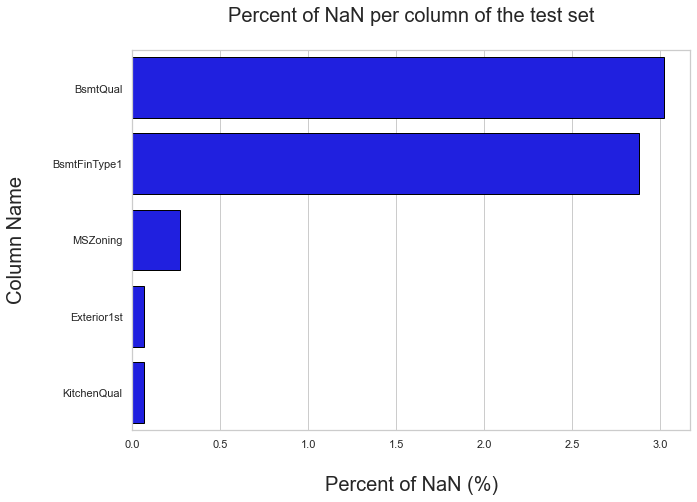

In [40]:
# Check the NaN of the test set by ploting percent of missing values per column
column_with_nan = df_test_categ.columns[df_test_categ.isnull().any()]
column_name = []
percent_nan = []

for i in column_with_nan:
    column_name.append(i)
    percent_nan.append(
        round(df_test_categ[i].isnull().sum() * 100 / len(df_test_categ), 2))

tab = pd.DataFrame(column_name, columns=["Column"])
tab["Percent_NaN"] = percent_nan
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


# Define figure parameters
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")

# Plot results
p = sns.barplot(x="Percent_NaN", y="Column", data=tab,
                edgecolor="black", color="blue")
p.set_title("Percent of NaN per column of the test set\n", fontsize=20)
p.set_xlabel("\nPercent of NaN (%)", fontsize=20)
p.set_ylabel("Column Name\n", fontsize=20)

In [41]:
# Fill the NaN of each feature by the corresponding modal class
categ_fill_null = {"BsmtQual": df_test_categ["BsmtQual"].mode().iloc[0],
                   "BsmtFinType1": df_test_categ["BsmtFinType1"].mode().iloc[0],
                   "MSZoning": df_test_categ["MSZoning"].mode().iloc[0],
                   "Exterior1st": df_test_categ["Exterior1st"].mode().iloc[0],
                   "KitchenQual": df_test_categ["KitchenQual"].mode().iloc[0]}

df_test_categ = df_test_categ.fillna(value=categ_fill_null)

In [42]:
# Transform Categorical features into Binary features

In [43]:
# Train set
for i in df_train_categ.columns.tolist()[:-1]:
    df_dummies = pd.get_dummies(df_train_categ[i], prefix=i)

    # merge both tables
    df_train_categ = df_train_categ.join(df_dummies)

# Select the binary features only
df_train_binary = df_train_categ.iloc[:, 18:]
df_train_binary.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,...,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,0,0,1,0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [44]:
# Test set
for i in df_test_categ.columns.tolist():
    df_dummies = pd.get_dummies(df_test_categ[i], prefix=i)

    # merge both tables
    df_test_categ = df_test_categ.join(df_dummies)

# Select the binary features only
df_test_binary = df_test_categ.iloc[:, 17:]
df_test_binary.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,...,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [45]:
# in df_test_binary there is 118 columns while in df_train_binary there is 122. Let's see which columns are missing from df_test_binary

In [46]:
dif_1 = [x for x in df_train_binary.columns if x not in df_test_binary.columns]
print(
    f"Features present in df_train_categ and absent in df_test_categ: {dif_1}\n")

dif_2 = [x for x in df_test_binary.columns if x not in df_train_binary.columns]
print(
    f"Features present in df_test_categ set and absent in df_train_categ: {dif_2}")

Features present in df_train_categ and absent in df_test_categ: ['HouseStyle_2.5Fin', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Electrical_Mix']

Features present in df_test_categ set and absent in df_train_categ: []


In [47]:
# Four of the binary features are absent from the test set. 
# Thus, these features will be dropped from the train in order to have the same columns in both data set

In [48]:
# Let's drop these columns from df_train_binary
df_train_binary.drop(dif_1, axis=1, inplace=True)

# Check again if the column headings are the same in both data set
dif_1 = [x for x in df_train_binary.columns if x not in df_test_binary.columns]
print(
    f"Features present in df_train_categ and absent in df_test_categ: {dif_1}\n")

dif_2 = [x for x in df_test_binary.columns if x not in df_train_binary.columns]
print(
    f"Features present in df_test_categ set and absent in df_train_categ: {dif_2}")

Features present in df_train_categ and absent in df_test_categ: []

Features present in df_test_categ set and absent in df_train_categ: []


In [49]:
# Add binary features to numreical features
# Train set
df_train_new = df_train_imputed.join(df_train_binary)
print(f"Train set: {df_train_new.shape}")

# Test set
df_test_new = df_test_imputed.join(df_test_binary)
print(f"Test set: {df_test_new.shape}")

Train set: (1460, 135)
Test set: (1459, 134)


In [50]:
# both features "WoodDeckSF" and "OpenPorchSF" a high number of 0 values with a correspondingly high price variation. 
# These outliers should be deleted.
# However, since the number of these outliers is very important, the best thing to do is to drop these columns.

In [51]:
# Drop "WoodDeckSF" and "OpenPorchSF"
df_train_new.drop(["WoodDeckSF", "OpenPorchSF"], axis=1, inplace=True)
df_test_new.drop(["WoodDeckSF", "OpenPorchSF"], axis=1, inplace=True)

In [52]:
# Let's handle the outliers in "GrLivArea", "TotalBsmtSF" and "GarageArea"
# Outliers in "GrLivArea"
outliers1 = df_train_new[(df_train_new["GrLivArea"] > 4000) & (
    df_train_new["SalePrice"] <= 200000)].index.tolist()

# Outliers in "TotalBsmtSF"
outliers2 = df_train_new[(df_train_new["TotalBsmtSF"] > 3000) & (
    df_train_new["SalePrice"] <= 400000)].index.tolist()

# Outliers in "GarageArea"
outliers3 = df_train_new[(df_train_new["GarageArea"] > 1200) & (
    df_train_new["SalePrice"] <= 300000)].index.tolist()

# List of all the outliers
outliers = outliers1 + outliers2 + outliers3
outliers = list(set(outliers))
print(outliers)

# Drop these outlier
df_train_new = df_train_new.drop(df_train_new.index[outliers])

# Reset index
df_train_new = df_train_new.reset_index().drop("index", axis=1)

[1061, 581, 1190, 523, 332, 1298]


In [53]:
# While looking closley at the remaining features, we can notice that several of them designate a given surface of the property. 
# Thus, I will try to combine some of these surfaces into indicators without losing the information they provide.

In [54]:
# Define a function to calculate the occupancy rate of the first floor of the total living area


def floor_occupation(x):
    """First floor occupation of the total live area

    floor_occupation equation has the following form:
    (1st Floor Area * 100) / (Ground Live Area)

    Args:
        x -- the corresponding feature

    Returns:
        0 -- if Ground Live Area = 0
        equation -- if Ground Live Area > 0
    """
    if x["GrLivArea"] == 0:
        return 0
    else:
        return x["1stFlrSF"] * 100 / x["GrLivArea"]


# Apply the function on train and test set
df_train_new["1stFlrPercent"] = df_train_new.apply(
    lambda x: floor_occupation(x), axis=1)

df_test_new["1stFlrPercent"] = df_test_new.apply(
    lambda x: floor_occupation(x), axis=1)

# Drop "1stFlrSF" and "2ndFlrSF"
df_train_new.drop(["1stFlrSF", "2ndFlrSF"], axis=1, inplace=True)
df_test_new.drop(["1stFlrSF", "2ndFlrSF"], axis=1, inplace=True)

In [55]:
# Define a function to calculate the occupancy rate of the finished basement area


def bsmt_finish(x):
    """Propotion of finished area in basement 

    bsmt_finish equation has the following form:
    (Finished Basement Area * 100) / (Total Basement Area)

    Args:
        x -- the corresponding feature

    Returns:
        0 -- if Total Basement Area = 0
        equation -- if Total Basement Area > 0
    """
    if x["TotalBsmtSF"] == 0:
        return 0
    else:
        return x["BsmtFinSF1"] * 100 / x["TotalBsmtSF"]


# Apply the function on train and test set
df_train_new["BsmtFinPercent"] = df_train_new.apply(
    lambda x: bsmt_finish(x), axis=1)

df_test_new["BsmtFinPercent"] = df_test_new.apply(
    lambda x: bsmt_finish(x), axis=1)

# Drop "BsmtFinSF1"
df_train_new.drop(["BsmtFinSF1"], axis=1, inplace=True)
df_test_new.drop(["BsmtFinSF1"], axis=1, inplace=True)

In [56]:
# Convert Year of construction to Age of the house since the construction
df_train_new["AgeSinceConst"] = (
    df_train_new["YearBuilt"].max() - df_train_new["YearBuilt"])

df_test_new["AgeSinceConst"] = df_test_new["YearBuilt"].max() - \
    df_test_new["YearBuilt"]

# Drop "YearBuilt"
df_train_new.drop(["YearBuilt"], axis=1, inplace=True)
df_test_new.drop(["YearBuilt"], axis=1, inplace=True)

In [57]:
# Convert Year of remodeling to Age of the house since the remodeling
df_train_new["AgeSinceRemod"] = (
    df_train_new["YearRemodAdd"].max() - df_train_new["YearRemodAdd"])

df_test_new["AgeSinceRemod"] = (
    df_test_new["YearRemodAdd"].max() - df_test_new["YearRemodAdd"])

# Drop "YearRemodAdd"
df_train_new.drop(["YearRemodAdd"], axis=1, inplace=True)
df_test_new.drop(["YearRemodAdd"], axis=1, inplace=True)

In [58]:
# To avoid redundancy and to mitigate the strong variations of some features according to the SalePrice. 
# I will use a log transformation for skewed features. Generally in real estate, as the area of the property increases,
# the price per square feet decreases, hence the use of log.

In [59]:
continuous_features = ["OverallQual", "TotalBsmtSF", "GrLivArea",
                       "FullBath", "TotRmsAbvGrd", "GarageCars", "GarageArea",
                       "MasVnrArea", "Fireplaces", "1stFlrPercent",
                       "BsmtFinPercent", "AgeSinceConst", "AgeSinceRemod"]
df_skew_verify = df_train_new.loc[:, continuous_features]

In [60]:
# Select features with absolute Skew higher than 0.5
skew_ft = []

for i in continuous_features:
    # list of skew for each corresponding feature
    skew_ft.append(abs(df_skew_verify[i].skew()))

df_skewed = pd.DataFrame({"Columns": continuous_features,
                          "Abs_Skew": skew_ft})

sk_features = df_skewed[df_skewed["Abs_Skew"] > 0.5]["Columns"].tolist()
print(f"List of skewed features: {sk_features}")

List of skewed features: ['GrLivArea', 'TotRmsAbvGrd', 'MasVnrArea', 'Fireplaces', 'AgeSinceConst', 'AgeSinceRemod']


In [61]:
# Log transformation of the skewed features
#sf_features = ["TotalBsmtSF", "GrLivArea", "MasVnrArea", "GarageArea"]

for i in sk_features:
    # loop over i (features) to calculate Log of surfaces
    # Train set
    df_train_new[i] = np.log((df_train_new[i])+1)
    
    # Test set
    df_test_new[i] = np.log((df_test_new[i])+1)

In [62]:
# Target variable 'SalePrice'
# log transformation of the independent variable ('SalePrice') to have a distribution that approaches the normal distribution

Text(0, 0.5, '')

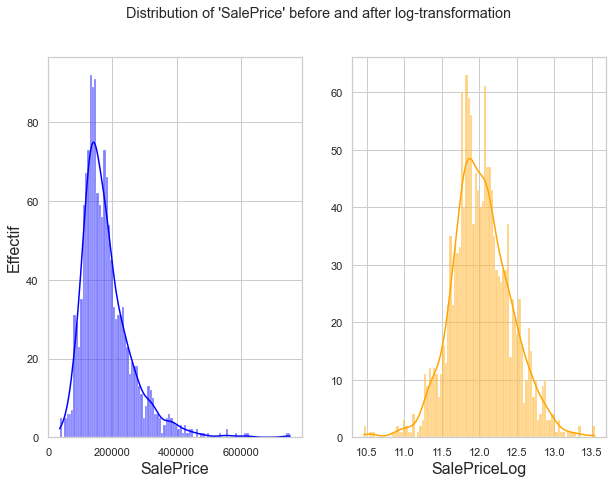

In [63]:
# Log transformation of the target variable "SalePrice"
df_train_new["SalePriceLog"] = np.log(df_train_new.SalePrice)

# Plot the distribution before and after transformation
fig, axes = plt.subplots(1, 2)
fig.suptitle("Distribution of 'SalePrice' before and after log-transformation")

# before log transformation
p = sns.histplot(ax=axes[0], x=df_train_new["SalePrice"],
                 kde=True, bins=100, color="blue")
p.set_xlabel("SalePrice", fontsize=16)
p.set_ylabel("Effectif", fontsize=16)

# after log transformation
q = sns.histplot(ax=axes[1], x=df_train_new["SalePriceLog"],
                 kde=True, bins=100, color="orange")
q.set_xlabel("SalePriceLog", fontsize=16)
q.set_ylabel("", fontsize=16)

In [64]:
# Drop the original SalePrice
df_train_new.drop(["SalePrice"], axis=1, inplace=True)

In [65]:
# Split data into train and test set and Standardization

In [66]:
# Extract the features (X) and the target (y)
# Features (X)
X = df_train_new[[i for i in list(
    df_train_new.columns) if i != "SalePriceLog"]]
print(X.shape)

# Target (y)
y = df_train_new.loc[:, "SalePriceLog"]
print(y.shape)

(1454, 131)
(1454,)


In [67]:
# Split into X_train and X_test (by stratifying on y)
# Stratify on a continuous variable by splitting it in bins
# Create the bins.
bins = np.linspace(0, len(y), 150)
y_binned = np.digitize(y, bins)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y_binned, shuffle=True)
print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")
print(f"\nX_test:{X_test.shape}\ny_test:{y_test.shape}")

X_train:(1163, 131)
y_train:(1163,)

X_test:(291, 131)
y_test:(291,)


In [68]:
# Standardize the data
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
# The same standardization is applied for df_test_new
df_test_new = std_scale.transform(df_test_new)


# The output of standardization is a vector. Let's turn it into a table
# Convert X, y and test data into dataframe
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
df_test_new = pd.DataFrame(df_test_new, columns=X.columns)

y_train = pd.DataFrame(y_train)
y_train = y_train.reset_index().drop("index", axis=1)

y_test = pd.DataFrame(y_test)
y_test = y_test.reset_index().drop("index", axis=1)

In [69]:
# Backward Stepwise Regression is a stepwise regression approach that begins with a full
# (saturated) model and at each step gradually eliminates variables from the regression model to find a
# reduced model that best explains the data. Also known as Backward Elimination regression.

In [70]:
Selected_Features = []


def backward_regression(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    """To select feature with Backward Stepwise Regression 

    Args:
        X -- features values
        y -- target variable
        initial_list -- features header
        threshold_in -- pvalue threshold of features to keep
        threshold_out -- pvalue threshold of features to drop
        verbose -- true to produce lots of logging output

    Returns:
        list of selected features for modeling 
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")


# Application of the backward regression function on our training data
backward_regression(X_train, y_train)

worst_feature : Exterior1st_Stucco, 0.9959233525454896 
worst_feature : Condition1_RRNe, 0.9939239109795132 
worst_feature : Condition1_RRAn, 0.9979919345624251 
worst_feature : LotShape_IR1, 0.9695285978125274 
worst_feature : SaleCondition_AdjLand, 0.9591285780246178 
worst_feature : RoofStyle_Hip, 0.9568273515177244 
worst_feature : Condition1_RRNn, 0.9467623220640462 
worst_feature : Electrical_FuseF, 0.9400380670175108 
worst_feature : Neighborhood_NPkVill, 0.8960013225545365 
worst_feature : Neighborhood_SawyerW, 0.993973295482905 
worst_feature : Neighborhood_Somerst, 0.9897422351917973 
worst_feature : Neighborhood_Gilbert, 0.9367581854512774 
worst_feature : Exterior1st_MetalSd, 0.8935606586730107 
worst_feature : Electrical_FuseA, 0.8472844117712153 
worst_feature : SaleCondition_Normal, 0.8531955330540006 
worst_feature : Exterior1st_AsphShn, 0.98370000388546 
worst_feature : Neighborhood_Timber, 0.8414824543858657 
worst_feature : HeatingQC_Gd, 0.7874156830232981 
worst_fea

In [71]:
# Keep the selected features only
X_train = X_train.loc[:, Selected_Features[0]]
X_test = X_test.loc[:, Selected_Features[0]]
df_test_new = df_test_new.loc[:, Selected_Features[0]]

In [72]:
# ariance inflation factor (VIF) is a measure of the amount of multicollinearity in a set of multiple regression variables. 
# Mathematically, the VIF for a regression model variable is equal to the ratio of the overall model variance to the variance 
# of a model that includes only that single independent variable.
# A feature with a VIF higher than 10 implies (5 is also common) that there is a multi-collinearity with the latter.

In [73]:
# Here I calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    X_train.values, i) for i in range(X_train.shape[1])]

# VIF results in a table
vif["features"] = X_train.columns
vif.round(1)

,VIF Factor,features
0,3.70,OverallQual
1,1.80,TotalBsmtSF
2,2.30,GrLivArea
3,5.70,GarageCars
4,5.40,GarageArea
5,1.60,Fireplaces
6,1.10,MSZoning_C (all)
7,1.60,MSZoning_FV
8,2.40,MSZoning_RL
9,1.10,LotConfig_Corner


In [74]:
# Select features with high VIF
high_vif_list = vif[vif["VIF Factor"] > 10]["features"].tolist()

if len(high_vif_list) == 0:
    # print empty list if low multicolinearity
    print(f"None of the features have a high multicollinearity")
else:
    # print list of features with high multicolinearity
    print(f"List of features with high multicollinearity: {high_vif_list}")

None of the features have a high multicollinearity


In [75]:
# Drop features with high multicollinearity from X_train, X_test and df_test_new
X_train.drop(high_vif_list, axis=1, inplace=True)

X_test.drop(high_vif_list, axis=1, inplace=True)

df_test_new.drop(high_vif_list, axis=1, inplace=True)

In [76]:
# By calculating Cook distance we can detect influential observations in a regression model. 
# Cook distance detects data with large residuals (outliers) that can distort the prediction and the accuracy of a regression.

In [77]:
X_constant = sm.add_constant(X_train)

model = sm.OLS(y_train, X_constant)
lr = model.fit()

# Cook distance
np.set_printoptions(suppress=True)

# Create an instance of influence
influence = lr.get_influence()

# Get Cook's distance for each observation
cooks = influence.cooks_distance

# Result as a dataframe
cook_df = pd.DataFrame({"Cook_Distance": cooks[0], "p_value": cooks[1]})
cook_df.head()

,Cook_Distance,p_value
0,0.00,1.00
1,0.00,1.00
2,0.00,1.00
3,0.00,1.00
4,0.00,1.00


In [78]:
# Remove the influential observation from X_train and y_train
influent_observation = cook_df[cook_df["p_value"] < 0.05].index.tolist()
print(f"Influential observations dropped: {influent_observation}")

# Drop these obsrevations
X_train = X_train.drop(X_train.index[influent_observation])
y_train = y_train.drop(y_train.index[influent_observation])

Influential observations dropped: []


<font color = 'white'> Here I am going to use RMSE and R² metrics in order to measure the performance of the selected models and their predictions.
    
<font color = 'white'>Then I will test the models that best meet the estimation of house prices. It's clearly a regression so here are the following models I will use:
- Ridge regression
- Lasso regression
- Elastic Net regression
- Support Vector regression (SVR)
- Random Forest regression
- XGBoost
- LigthGBM
    <font>

In [79]:
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [80]:
# Let's define a function for each metrics
# R²
def rsqr_score(test, pred):
    """Calculate R squared score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        R squared score 
    """
    r2_ = r2_score(test, pred)
    return r2_


# RMSE
def rmse_score(test, pred):
    """Calculate Root Mean Square Error score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        Root Mean Square Error score
    """
    rmse_ = np.sqrt(mean_squared_error(test, pred))
    return rmse_


# Print the scores
def print_score(test, pred):
    """Print calculated score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        print the regressor name
        print the R squared score
        print Root Mean Square Error score
    """

    print(f"- Regressor: {regr.__class__.__name__}")
    print(f"R²: {rsqr_score(test, pred)}")
    print(f"RMSE: {rmse_score(test, pred)}\n")

In [81]:
# Define regression models
ridge = Ridge()
lasso = Lasso(alpha=0.001)
elastic = ElasticNet(alpha=0.001)
svr = SVR()
rdf = RandomForestRegressor()
xgboost = XGBRegressor()
lgbm = LGBMRegressor()

# Train models on X_train and y_train
for regr in [ridge, lasso, elastic, svr, rdf, xgboost, lgbm]:
    # fit the corresponding model
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    # Print the defined metrics above for each classifier
    print_score(y_test, y_pred)

- Regressor: Ridge
R²: 0.8830938161760374
RMSE: 0.1399784734888956

- Regressor: Lasso
R²: 0.8837483417856802
RMSE: 0.13958607297149173

- Regressor: ElasticNet
R²: 0.8834697988056452
RMSE: 0.1397531994422318

- Regressor: SVR
R²: 0.7604621004056124
RMSE: 0.20036858425794024

- Regressor: RandomForestRegressor
R²: 0.8564856345157501
RMSE: 0.1550922864660545

- Regressor: XGBRegressor
R²: 0.8804879335024363
RMSE: 0.14152996165645212

- Regressor: LGBMRegressor
R²: 0.8533047883770805
RMSE: 0.15680159644188194



In [82]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters
alphas = np.logspace(-5, 5, 50).tolist()

tuned_parameters = {"alpha": alphas}

# GridSearch
ridge_cv = GridSearchCV(Ridge(), tuned_parameters, cv=10, n_jobs=-1, verbose=1)

# fit the GridSearch on train set
ridge_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {ridge_cv.best_params_}")
print(f"Best R² (train): {ridge_cv.best_score_}")

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best hyperparameters: {'alpha': 86.85113737513521}
Best R² (train): 0.9086052604071325


In [83]:
# Ridge Regressor with the best hyperparameters
ridge_mod = Ridge(alpha=ridge_cv.best_params_["alpha"])

# Fit the model on train set
ridge_mod.fit(X_train, y_train)

# Predict on test set
y_pred = ridge_mod.predict(X_test)

print(f"- {ridge_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")

- Ridge
R²: 0.8809447642752782
RMSE: 0.14125920595938868


In [84]:
# Save the model results into lists
model_list = []
r2_list = []
rmse_list = []

model_list.append(ridge_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))

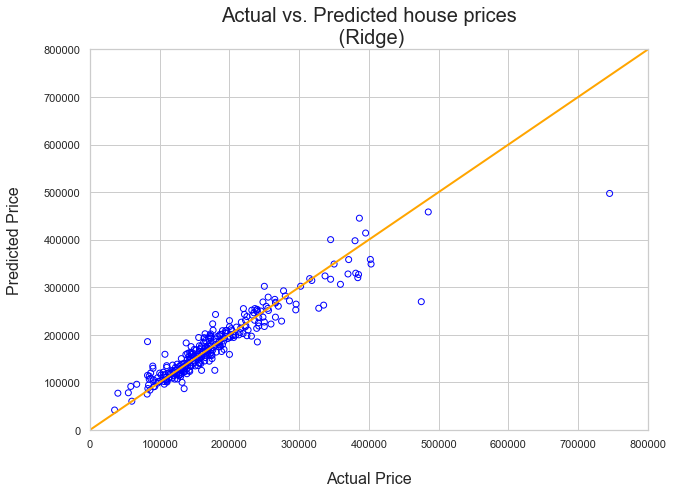

In [85]:
# Plot Actual vs. Predicted house prices
actual_price = np.exp(y_test["SalePriceLog"])
predicted_price = np.exp(y_pred)

plt.figure()
plt.title("Actual vs. Predicted house prices\n (Ridge)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="blue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "orange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

In [86]:
# Define hyperparameters
alphas = np.logspace(-5, 5, 50).tolist()

tuned_parameters = {"alpha": alphas}

# GridSearch
lasso_cv = GridSearchCV(Lasso(), tuned_parameters, cv=10, n_jobs=-1, verbose=1)

# fit the GridSearch on train set
lasso_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {lasso_cv.best_params_}")
print(f"Best R² (train): {lasso_cv.best_score_}")

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best hyperparameters: {'alpha': 0.001757510624854793}
Best R² (train): 0.9081591120937935


In [87]:
# Lasso Regressor with the best hyperparameters
lasso_mod = Lasso(alpha=lasso_cv.best_params_["alpha"])

# Fit the model on train set
lasso_mod.fit(X_train, y_train)

# Predict on test set
y_pred = lasso_mod.predict(X_test)

print(f"- {lasso_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")

- Lasso
R²: 0.883958679048967
RMSE: 0.13945973737512204


In [88]:
# Save the model results into lists
model_list.append(lasso_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))

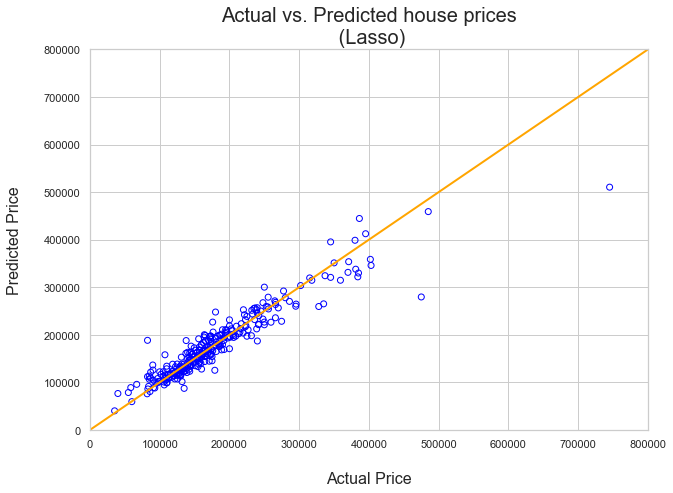

In [89]:
# Plot Actual vs. Predicted house prices
actual_price = np.exp(y_test["SalePriceLog"])
predicted_price = np.exp(y_pred)

plt.figure()
plt.title("Actual vs. Predicted house prices\n (Lasso)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="blue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "orange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

In [90]:
# Define hyperparameters
tuned_parameters = {"max_depth": [3],
                    "colsample_bytree": [0.3, 0.7],
                    "learning_rate": [0.01, 0.05, 0.1],
                    "n_estimators": [100, 500]}

# GridSearch
xgbr_cv = GridSearchCV(estimator=XGBRegressor(),
                       param_grid=tuned_parameters,
                       cv=5,
                       n_jobs=-1,
                       verbose=1)

# fit the GridSearch on train set
xgbr_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {xgbr_cv.best_params_}\n")
print(f"Best R²: {xgbr_cv.best_score_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}

Best R²: 0.8969760952216481


In [91]:
# XGB Regressor with the best hyperparameters
xgbr_mod = XGBRegressor(seed=20,
                        colsample_bytree=xgbr_cv.best_params_["colsample_bytree"],
                        learning_rate=xgbr_cv.best_params_["learning_rate"],
                        max_depth=xgbr_cv.best_params_["max_depth"],
                        n_estimators=xgbr_cv.best_params_["n_estimators"])

# Fit the model on train set
xgbr_mod.fit(X_train, y_train)

# Predict on test set
y_pred = xgbr_mod.predict(X_test)

print(f"- {xgbr_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")

- XGBRegressor
R²: 0.8903882003584518
RMSE: 0.135541149707004


In [92]:
# Save the model results into lists
model_list.append(xgbr_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))

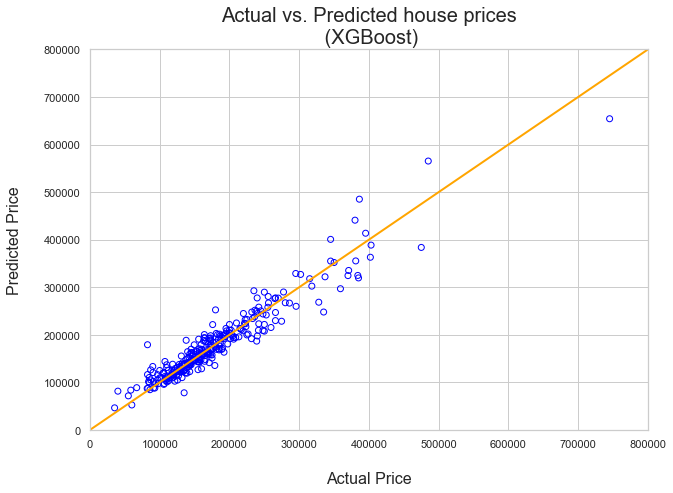

In [93]:
# Plot Actual vs. Predicted house prices
actual_price = np.exp(y_test["SalePriceLog"])
predicted_price = np.exp(y_pred)

plt.figure()
plt.title("Actual vs. Predicted house prices\n (XGBoost)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="blue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "orange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

In [94]:
# Define hyperparameters
tuned_parameters = {"max_depth": [3, 6, 10], "learning_rate": [
    0.01, 0.05, 0.1], "n_estimators": [100, 500, 1000], }

# GridSearch
lgbm_cv = GridSearchCV(estimator=LGBMRegressor(
), param_grid=tuned_parameters, cv=10, n_jobs=-1, verbose=1)

# fit the GridSearch on train set
lgbm_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {lgbm_cv.best_params_}\n")
print(f"Best R²: {lgbm_cv.best_score_}")

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}

Best R²: 0.8888998535916224


In [95]:
# LGBM Regressor with the best hyperparameters
lgbm_mod = LGBMRegressor(learning_rate=lgbm_cv.best_params_["learning_rate"],
                         max_depth=lgbm_cv.best_params_["max_depth"],
                         n_estimators=lgbm_cv.best_params_["n_estimators"])

# Fit the model on train set
lgbm_mod.fit(X_train, y_train)

# Predict on test set
y_pred = lgbm_mod.predict(X_test)

print(f"- {lgbm_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")

- LGBMRegressor
R²: 0.862903846867959
RMSE: 0.1515846221280656


In [96]:
# Save the model results into lists
model_list.append(lgbm_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))

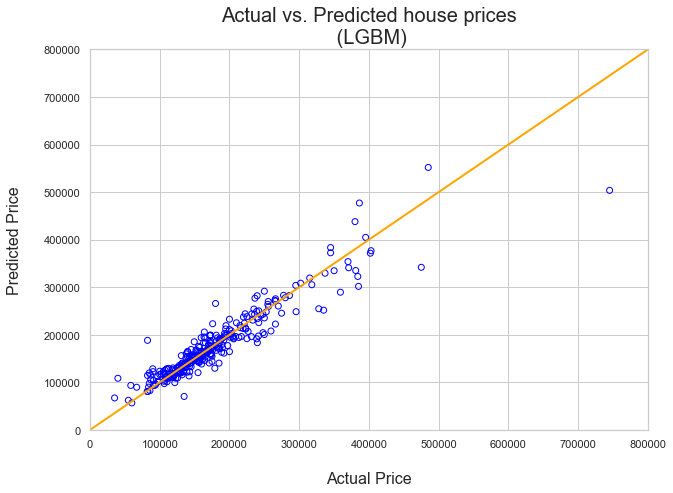

In [97]:
# Plot Actual vs. Predicted house prices
actual_price = np.exp(y_test["SalePriceLog"])
predicted_price = np.exp(y_pred)

plt.figure()
plt.title("Actual vs. Predicted house prices\n (LGBM)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="blue", marker="o", facecolors="none")
plt.plot([0, 800000], [0, 800000], "orange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

In [98]:
# Create a table with pd.DataFrame
model_results = pd.DataFrame({"Model": model_list,
                              "R²": r2_list,
                              "RMSE": rmse_list})

model_results

,Model,R²,RMSE
0,Ridge,0.88,0.14
1,Lasso,0.88,0.14
2,XGBRegressor,0.89,0.14
3,LGBMRegressor,0.86,0.15


In [99]:
# Predictions from Ridge model
predictions_list = xgbr_mod.predict(df_test_new)

# Conversion of logarithmic predictions to logical data Sale Price
saleprice_preds = np.exp(predictions_list)

# DataFrame of test ID and their corresponding predictions
output = pd.DataFrame({"Id": Id_test_list,
                       "SalePrice": saleprice_preds})
output.head(10)

,Id,SalePrice
0,1461,"116,871.91"
1,1462,"155,241.44"
2,1463,"176,779.72"
3,1464,"186,456.80"
4,1465,"191,553.22"
5,1466,"171,873.16"
6,1467,"161,724.78"
7,1468,"159,542.77"
8,1469,"191,562.16"
9,1470,"128,648.62"


In [100]:
# Save the output
output.to_csv("submission.csv", index=False)